In [1]:
import torch
import torch.nn as nn

from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torchvision.datasets.utils import download_url
import matplotlib.pyplot as plt
import numpy as np
import json

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = datasets.ImageFolder(root='./data/', transform=transform)

dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

vgg19(pretrained=True)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [2]:

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()

        # pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)

        # access its last convolutional layer
        self.features_conv = self.vgg.features[:36]

        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier

        # placeholder for the gradients
        self.gradients = None

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x

    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients

    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [3]:
# Download class labels from imagenet dataset
download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")

with open("imagenet_class_index.json", "r") as h:
    labels = json.load(h)

Using downloaded and verified file: ./imagenet_class_index.json


In [4]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img)#.argmax(dim=1)
print(pred)

tensor([[ 1.0530e+01,  5.2559e+00,  3.1950e+01,  2.9110e+01,  2.1745e+01,
          1.9936e+01,  1.7560e+01, -1.7517e+00,  7.6880e-01,  6.5517e-01,
          2.0035e+00,  3.0536e+00,  2.4741e+00,  4.1158e+00,  1.8742e+00,
          4.0138e-01, -7.3129e-01,  3.4425e+00,  5.4254e-01,  1.7525e+00,
          2.4739e-03,  8.2529e+00,  5.6675e+00,  5.2600e+00, -2.2888e-01,
         -3.0417e+00,  1.9738e+00, -1.1138e+00,  2.7854e+00,  7.4719e+00,
          3.7036e+00, -8.2108e-02,  1.4166e+00,  1.3926e+01,  1.5403e+01,
          3.1858e+00,  7.3190e+00, -4.7898e+00,  2.3757e+00, -3.2123e-01,
          2.5910e-01,  7.0697e-01, -5.2049e+00, -4.9949e+00,  9.1579e-01,
         -4.4130e+00, -2.8869e+00, -6.2484e+00, -1.8028e+00,  2.5439e+00,
          9.3769e+00,  1.9010e+00,  1.6113e+00, -5.4286e-01,  1.7258e+00,
         -3.6749e-01, -1.7974e+00, -9.1346e-01,  4.1153e+00,  1.0220e+00,
          2.8276e+00,  1.8567e+00,  1.6727e+00,  3.1716e+00,  1.8929e+00,
          8.6295e+00, -5.6714e-01, -8.

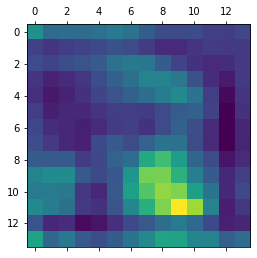

In [5]:
# get the gradient of the output with respect to the parameters of the model
pred[:, 2].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [6]:
import cv2
img = np.asarray(cv2.imread('./data/Shark/shark.jpg'))
dsize = (img.shape[1], img.shape[0])
heatmap_arr = np.asarray(heatmap)
heatmap = cv2.resize(heatmap_arr, dsize)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)
#img2 = superimposed_img[:,:,::-1]
#plt.imshow(img2)

True